# Virtual bidding in NYISO's markets


In this lab, we will implement a simple virtual trading strategy in New York
ISO's electricity markets. The goal is to maximize profits. We shall train our
model on price data from one year, and implement the strategy on the data from
the next year. How much can you earn with a certain daily budget? Say \$250K?

We will present a trading strategy. You are welcome to try other strategies and compare the gains over multiple runs.

Let's start with customary imports.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import choice
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## Load the day-ahead and real-time prices from 11 zones in New York.

The day-ahead prices are defined every hour. The real-time market runs every 5 minutes. For each zone, an average of
these prices over an hour is published.

Store the list of zones in the variable 'listOfZones'. Also, store the number of options
as the number of zones times the 24 hours available for trading. Finally create another
list containing the option names (zone + hour).

In [2]:
listOfZones = ['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL', 'LONGIL', 'MHK VL',
               'MILLWD', 'N.Y.C.', 'NORTH', 'WEST']

nOptions = len(listOfZones) * 24
optionNames = [zone + "_Hour_" + str(t) for zone in listOfZones for t in range(24)]


## Parse the files with DA and RT prices along with DA load forecast.

Define a function that parses three files containing DA and RT prices, along with DA load predictions from a year from all different zones in the list defined before. This function will be used for to both load the data for training the classifiers and testing them. This function has 3 outputs: they are DA prices, difference between DA and RT prices, and finally DA load predictions. The outputs are pandas data frames whose columns are the options, and rows are the days in the year.

In [3]:
def loadNYISOData(year):

    # Open the relevant files for DA prices, RT prices, DA load.

    dfPriceDA = pd.read_csv("DAM_NYISO_Zonal_LBMP_" + str(year) + ".csv")
    dfPriceRT = pd.read_csv("RTM_NYISO_Zonal_LBMP_" + str(year) + ".csv")
    dfLoadDA = pd.read_csv("DAM_NYISO_LoadForecast_" + str(year) + ".csv")

    # Collect the DA and RT prices from each zone from each hour and create a pandas list.
    # The data should have prices and loads from all days of a year, where each day
    # contributes 24 rows, corresponding to each hour.

    priceDA = pd.DataFrame({zone: (dfPriceDA.loc[dfPriceDA['Zone Name'] == zone,
                                                 'DAM Zonal LBMP']).values
                             for zone in listOfZones})
    priceRT = pd.DataFrame({zone: (dfPriceRT.loc[dfPriceRT['Zone Name'] == zone,
                                                 'TWI Zonal LBMP']).values
                             for zone in listOfZones})
    loadDA = pd.DataFrame({zone: (dfLoadDA.loc[dfLoadDA['Zone Name'] == zone,
                                               'DAM Forecast Load']).values
                            for zone in listOfZones})

    numberOfDays = int(len(priceDA.index)/24)

    # Compute the price differences between DA and RT prices for all options on
    # all days of the year. Store it as a pandas data frame where the 24 rows for
    # each day is flattened into one row. This operation essentially allows us to
    # independently think of each zone in each hour as a separate option. Also,
    # reshape the prices for the DA market in the same manner.

    priceDART = pd.DataFrame([priceRT.sub(priceDA).loc[day * 24:
                                                              (day + 1) * 24 - 1,
                              listOfZones].values.flatten()
                              for day in range(numberOfDays)],
                             columns=optionNames)

    priceDA = pd.DataFrame([priceDA.loc[day * 24: (day + 1) * 24 - 1,
                            listOfZones].values.flatten()
                            for day in range(numberOfDays)],
                           columns=optionNames)

    return priceDA, priceDART, loadDA


## Create a function that creates the inputs for training a classifier

Create a function that takes the price and load data and creates two arrays
'X' and 'Y'. Essentially, the rows of 'X' contains all information relevant to
 predicting the sign of the price difference on the various options on the next day.
 It takes as an input, three pandas frames corresponding to the DA prices, price
 differences, and the DA load predictions, and produces three outputs:
 the arrays 'X', 'Y', and the range of days from the year that were used to
 create the data 'X' and 'Y'. This function will be used to both train and
 test classifiers.

In [4]:
def createClassifierIO(priceDA, priceDART, loadDA):

    # Define how many past days of prices to use for classification.

    pastPrices = range(1, 3)

    # Define how many past days of load predictions to use for classification.

    pastLoad = range(1, 3)

    # Define a date range within the year to create the arrays 'X' and 'Y' in a way
    # that past price and load data for the first day is within the date range in the
    # pandas frames passed as inputs.

    rangeOfDays = range(3, len(priceDA.index))

    # 'X' will contain three sets of variables:
    #   1. the DA prices from past days in the list 'pastDays',
    #   2. the differences between DA and RT prices from the same past days,
    #   3. the load predictions from past days in the list 'pastLoad'

    X = [np.concatenate((
        priceDA.loc[[(day - h) for h in pastPrices]].values.flatten(),
        priceDART.loc[[(day - h) for h in pastPrices]].values.flatten(),
        loadDA.loc[[(day - h) for h in pastLoad]].values.flatten()
    )) for day in rangeOfDays]

    # Scale the array 'X' to make its data zero mean and unit variance.
    X = StandardScaler().fit_transform(X)

    # 'Y' will contain zeros and ones, where a one indicates that the price in DA is
    # higher than in RT for a particular option. Recall that an option corresponds to
    # a zone at a particular hour of the day.

    Y = np.array([(priceDART.loc[day].values > 0).astype(int)
                  for day in rangeOfDays])

    # Return the arrays 'X' and 'Y', and finally the range of days from the year that
    # will be utilized for training or testing the classifier.
    return X, Y, rangeOfDays

## Design the training module.
 The training module utilizes a year's worth of data to determine the following for
 each option, i.e., for each zone for each hour of the day:
   1. Classifiers that predict the sign of the difference between DA and RT prices.
   2. Statistics of the mean of the price difference.
   3. A quantile of the day-ahead prices that we will use as our bid for each option.
 You will either train the classifiers here or load them from the folder './Classifiers'.
 Storing the classifiers from time to time allows you to only vary the bidding strategy
 and observe the annual reward rather than having to train the classifiers every time.
 
### Define and train the classifiers or load pre-trained classifiers.

In [5]:
classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.


    classifiers = [MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=200)
                   for _ in range(nOptions)]

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    print("All training variables were loaded successfully...\n")

Starting training module...

Loaded hourly prices from 2015 for 365 days.
Classifier trained for option CAPITL_Hour_0
Classifier trained for option CAPITL_Hour_1
Classifier trained for option CAPITL_Hour_2
Classifier trained for option CAPITL_Hour_3
Classifier trained for option CAPITL_Hour_4
Classifier trained for option CAPITL_Hour_5
Classifier trained for option CAPITL_Hour_6
Classifier trained for option CAPITL_Hour_7
Classifier trained for option CAPITL_Hour_8
Classifier trained for option CAPITL_Hour_9
Classifier trained for option CAPITL_Hour_10
Classifier trained for option CAPITL_Hour_11
Classifier trained for option CAPITL_Hour_12
Classifier trained for option CAPITL_Hour_13
Classifier trained for option CAPITL_Hour_14
Classifier trained for option CAPITL_Hour_15
Classifier trained for option CAPITL_Hour_16
Classifier trained for option CAPITL_Hour_17
Classifier trained for option CAPITL_Hour_18
Classifier trained for option CAPITL_Hour_19
Classifier trained for option CAPITL

C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CAPITL_Hour_21
Classifier trained for option CAPITL_Hour_22
Classifier trained for option CAPITL_Hour_23
Classifier trained for option CENTRL_Hour_0
Classifier trained for option CENTRL_Hour_1
Classifier trained for option CENTRL_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CENTRL_Hour_3
Classifier trained for option CENTRL_Hour_4
Classifier trained for option CENTRL_Hour_5
Classifier trained for option CENTRL_Hour_6
Classifier trained for option CENTRL_Hour_7
Classifier trained for option CENTRL_Hour_8
Classifier trained for option CENTRL_Hour_9
Classifier trained for option CENTRL_Hour_10
Classifier trained for option CENTRL_Hour_11
Classifier trained for option CENTRL_Hour_12
Classifier trained for option CENTRL_Hour_13
Classifier trained for option CENTRL_Hour_14
Classifier trained for option CENTRL_Hour_15
Classifier trained for option CENTRL_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CENTRL_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CENTRL_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CENTRL_Hour_19
Classifier trained for option CENTRL_Hour_20
Classifier trained for option CENTRL_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CENTRL_Hour_22
Classifier trained for option CENTRL_Hour_23
Classifier trained for option DUNWOD_Hour_0
Classifier trained for option DUNWOD_Hour_1
Classifier trained for option DUNWOD_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_4
Classifier trained for option DUNWOD_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_7
Classifier trained for option DUNWOD_Hour_8
Classifier trained for option DUNWOD_Hour_9
Classifier trained for option DUNWOD_Hour_10
Classifier trained for option DUNWOD_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_12
Classifier trained for option DUNWOD_Hour_13
Classifier trained for option DUNWOD_Hour_14
Classifier trained for option DUNWOD_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_16
Classifier trained for option DUNWOD_Hour_17
Classifier trained for option DUNWOD_Hour_18
Classifier trained for option DUNWOD_Hour_19
Classifier trained for option DUNWOD_Hour_20
Classifier trained for option DUNWOD_Hour_21
Classifier trained for option DUNWOD_Hour_22
Classifier trained for option DUNWOD_Hour_23
Classifier trained for option GENESE_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_2
Classifier trained for option GENESE_Hour_3
Classifier trained for option GENESE_Hour_4
Classifier trained for option GENESE_Hour_5
Classifier trained for option GENESE_Hour_6
Classifier trained for option GENESE_Hour_7
Classifier trained for option GENESE_Hour_8
Classifier trained for option GENESE_Hour_9
Classifier trained for option GENESE_Hour_10
Classifier trained for option GENESE_Hour_11
Classifier trained for option GENESE_Hour_12
Classifier trained for option GENESE_Hour_13
Classifier trained for option GENESE_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_15
Classifier trained for option GENESE_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_17
Classifier trained for option GENESE_Hour_18
Classifier trained for option GENESE_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_20
Classifier trained for option GENESE_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_22
Classifier trained for option GENESE_Hour_23
Classifier trained for option HUD VL_Hour_0
Classifier trained for option HUD VL_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_3
Classifier trained for option HUD VL_Hour_4
Classifier trained for option HUD VL_Hour_5
Classifier trained for option HUD VL_Hour_6
Classifier trained for option HUD VL_Hour_7
Classifier trained for option HUD VL_Hour_8
Classifier trained for option HUD VL_Hour_9
Classifier trained for option HUD VL_Hour_10
Classifier trained for option HUD VL_Hour_11
Classifier trained for option HUD VL_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_13
Classifier trained for option HUD VL_Hour_14
Classifier trained for option HUD VL_Hour_15
Classifier trained for option HUD VL_Hour_16
Classifier trained for option HUD VL_Hour_17
Classifier trained for option HUD VL_Hour_18
Classifier trained for option HUD VL_Hour_19
Classifier trained for option HUD VL_Hour_20
Classifier trained for option HUD VL_Hour_21
Classifier trained for option HUD VL_Hour_22
Classifier trained for option HUD VL_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_0
Classifier trained for option LONGIL_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_4
Classifier trained for option LONGIL_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_8
Classifier trained for option LONGIL_Hour_9
Classifier trained for option LONGIL_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_11
Classifier trained for option LONGIL_Hour_12
Classifier trained for option LONGIL_Hour_13
Classifier trained for option LONGIL_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_17
Classifier trained for option LONGIL_Hour_18
Classifier trained for option LONGIL_Hour_19
Classifier trained for option LONGIL_Hour_20
Classifier trained for option LONGIL_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_22
Classifier trained for option LONGIL_Hour_23
Classifier trained for option MHK VL_Hour_0
Classifier trained for option MHK VL_Hour_1
Classifier trained for option MHK VL_Hour_2
Classifier trained for option MHK VL_Hour_3
Classifier trained for option MHK VL_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_5
Classifier trained for option MHK VL_Hour_6
Classifier trained for option MHK VL_Hour_7
Classifier trained for option MHK VL_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_9
Classifier trained for option MHK VL_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_11
Classifier trained for option MHK VL_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_13
Classifier trained for option MHK VL_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_15
Classifier trained for option MHK VL_Hour_16
Classifier trained for option MHK VL_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_18
Classifier trained for option MHK VL_Hour_19
Classifier trained for option MHK VL_Hour_20
Classifier trained for option MHK VL_Hour_21
Classifier trained for option MHK VL_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_3
Classifier trained for option MILLWD_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_6
Classifier trained for option MILLWD_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_8
Classifier trained for option MILLWD_Hour_9
Classifier trained for option MILLWD_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_11
Classifier trained for option MILLWD_Hour_12
Classifier trained for option MILLWD_Hour_13
Classifier trained for option MILLWD_Hour_14
Classifier trained for option MILLWD_Hour_15
Classifier trained for option MILLWD_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_17
Classifier trained for option MILLWD_Hour_18
Classifier trained for option MILLWD_Hour_19
Classifier trained for option MILLWD_Hour_20
Classifier trained for option MILLWD_Hour_21
Classifier trained for option MILLWD_Hour_22
Classifier trained for option MILLWD_Hour_23
Classifier trained for option N.Y.C._Hour_0
Classifier trained for option N.Y.C._Hour_1
Classifier trained for option N.Y.C._Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_3
Classifier trained for option N.Y.C._Hour_4
Classifier trained for option N.Y.C._Hour_5
Classifier trained for option N.Y.C._Hour_6
Classifier trained for option N.Y.C._Hour_7
Classifier trained for option N.Y.C._Hour_8
Classifier trained for option N.Y.C._Hour_9
Classifier trained for option N.Y.C._Hour_10
Classifier trained for option N.Y.C._Hour_11
Classifier trained for option N.Y.C._Hour_12
Classifier trained for option N.Y.C._Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_15
Classifier trained for option N.Y.C._Hour_16
Classifier trained for option N.Y.C._Hour_17
Classifier trained for option N.Y.C._Hour_18
Classifier trained for option N.Y.C._Hour_19
Classifier trained for option N.Y.C._Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_21
Classifier trained for option N.Y.C._Hour_22
Classifier trained for option N.Y.C._Hour_23
Classifier trained for option NORTH_Hour_0
Classifier trained for option NORTH_Hour_1
Classifier trained for option NORTH_Hour_2
Classifier trained for option NORTH_Hour_3
Classifier trained for option NORTH_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_8
Classifier trained for option NORTH_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_12
Classifier trained for option NORTH_Hour_13
Classifier trained for option NORTH_Hour_14
Classifier trained for option NORTH_Hour_15
Classifier trained for option NORTH_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_17
Classifier trained for option NORTH_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_19
Classifier trained for option NORTH_Hour_20
Classifier trained for option NORTH_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_22
Classifier trained for option NORTH_Hour_23
Classifier trained for option WEST_Hour_0
Classifier trained for option WEST_Hour_1
Classifier trained for option WEST_Hour_2
Classifier trained for option WEST_Hour_3
Classifier trained for option WEST_Hour_4
Classifier trained for option WEST_Hour_5
Classifier trained for option WEST_Hour_6
Classifier trained for option WEST_Hour_7
Classifier trained for option WEST_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_9
Classifier trained for option WEST_Hour_10
Classifier trained for option WEST_Hour_11
Classifier trained for option WEST_Hour_12
Classifier trained for option WEST_Hour_13
Classifier trained for option WEST_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_16
Classifier trained for option WEST_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_19
Classifier trained for option WEST_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_21
Classifier trained for option WEST_Hour_22
Classifier trained for option WEST_Hour_23

Overall training accuracy = 99.98 percent.


### Test the classifier's accuracy on test data.

In [9]:
# First, load the test data from NYISO for the year 2016. Again, utilize our function
# named 'loadNYISOData'.

print("Starting the testing module...\n")
testPriceDA, testPriceDART, testLoadDA = loadNYISOData(2016)

# Create the data for the classifier using the function 'createClassifierIO'.
testX, testY, rangeOfDays = createClassifierIO(testPriceDA, testPriceDART, testLoadDA)

# The next step is not useful for implementing the trading strategy, but quickly check how accurate
# your trained classifiers are for the test data. Training accuracy is not always indicative of
# test accuracy.

testingAccuracy = [classifiers[ii].score(testX, testY[:, ii]) for ii in range(nOptions)]
print("Test Accuracy Stats: Min = %.2f%%, Avg = %.2f%%, Max = %.2f%%" %
      (100 * np.min(testingAccuracy),
       100 * np.mean(testingAccuracy),
       100 * np.max(testingAccuracy)))

# Utilize the classifiers to predict the sign of DA - RT prices for each day in 'rangeOfDays' for
# the test data. Store the result in a pandas data frame with columns as the option names and the
# day in year as index.
predictedY = pd.DataFrame(np.column_stack([classifiers[ii].predict(testX) for ii in range(nOptions)]),
                          columns=optionNames, index=rangeOfDays)

Starting the testing module...

Test Accuracy Stats: Min = 46.01%, Avg = 58.78%, Max = 67.49%


## Design and implement the trading strategy. 

We define a fairly simple trading strategy. Define a total budget that you are willing to spend in the DA market. Recall that we only invest in
options where we buy at the DA market and sell at the RT market. When your bid for one unit of an option
clears in the DA market, you have to pay the DA price for that option. There are two possibilities:
  1. Your bid clears: Therefore, your offer price was higher than the DA price.
  2. Your bid does not clear: Then, the DA price was higher than your bid.
In both these cases, the maximum you have to pay is your bid. Therefore, we will enforce that your bids
across all options in a day does not exceed your total budget.
Keep track of how rewards grow (or fall) through the year
as you utilize your strategy. Also, keep track of how much rewards you get from each option. We shall
visualize these results after implementing the trading strategy over the NYISO data for 2016.

Choose the bid prices as a suitable quantile of the historical DA prices. The higher the quantile, the
better your chances are that your bid will be cleared. However, a higher quantile also indicates that
you are budgeting more money for each option, and hence, you will buy fewer options.

In [10]:
dailyBudget = 250000
quantileOffer =0.8

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Day 3: Reward (in $) = -91,353
Day 4: Reward (in $) = 1,003,324
Day 5: Reward (in $) = 12,981
Day 6: Reward (in $) = -23,884
Day 7: Reward (in $) = -30,539
Day 8: Reward (in $) = 20,625
Day 9: Reward (in $) = -40,277
Day 10: Reward (in $) = -104,473
Day 11: Reward (in $) = -75,837
Day 12: Reward (in $) = -44,464
Day 13: Reward (in $) = -17,924
Day 14: Reward (in $) = -27,640
Day 15: Reward (in $) = 14,512
Day 16: Reward (in $) = 39,306
Day 17: Reward (in $) = -52,809
Day 18: Reward (in $) = -25,794
Day 19: Reward (in $) = 15,858
Day 20: Reward (in $) = -4,885
Day 21: Reward (in $) = 18,216
Day 22: Reward (in $) = 99,445
Day 23: Reward (in $) = 29,654
Day 24: Reward (in $) = -85,692
Day 25: Reward (in $) = -30,330
Day 26: Reward (in $) = -20,771
Day 27: Reward (in $) = -6,742
Day 28: Reward (in $) = -16,899
Day 29: Reward (in $) = -20,959
Day 30: Reward (in $) = -26,320
Day 31: Reward (in $) = -28,414
Day 32: Reward (in $) = -9,301
Day 33: Reward (in $) = -102,235
Day 34: Reward (in $) 

Day 260: Reward (in $) = -26,605
Day 261: Reward (in $) = 13,704
Day 262: Reward (in $) = 20,715
Day 263: Reward (in $) = 4,086
Day 264: Reward (in $) = -40,281
Day 265: Reward (in $) = -8,389
Day 266: Reward (in $) = -68,689
Day 267: Reward (in $) = -9,306
Day 268: Reward (in $) = -23,255
Day 269: Reward (in $) = -67,633
Day 270: Reward (in $) = -71,888
Day 271: Reward (in $) = -22,813
Day 272: Reward (in $) = -62,072
Day 273: Reward (in $) = -53,024
Day 274: Reward (in $) = 17,932
Day 275: Reward (in $) = 27,468
Day 276: Reward (in $) = 9,389
Day 277: Reward (in $) = 42,123
Day 278: Reward (in $) = 187,540
Day 279: Reward (in $) = -1,192
Day 280: Reward (in $) = 17,036
Day 281: Reward (in $) = -13,150
Day 282: Reward (in $) = -346
Day 283: Reward (in $) = -13,436
Day 284: Reward (in $) = 24,118
Day 285: Reward (in $) = -27,718
Day 286: Reward (in $) = -55,326
Day 287: Reward (in $) = -64,922
Day 288: Reward (in $) = 12,644
Day 289: Reward (in $) = 19,009
Day 290: Reward (in $) = 5,99

### Task1:  Visualize the rewards (25 points)

We would like to plot the cumulative reward over the year 2016. By cumulative reward on a particular date, we mean the total reward from the start of the year till that date.

Also, plot a heat map of the returns from each option. 

#### Fill in the missing lines below.

C:\Users\Katherine\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


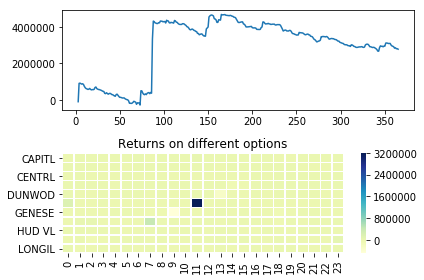

In [16]:
# Plot the cumulative reward over the year 2016. Also, plot a heat map of the returns from
# each option.

fig, axs = plt.subplots(2, 1, tight_layout=True)
axs = axs.ravel()


## Enter code here where you plot in axs[0].
rewards = sorted(cumulativeReward.items())
x_axis,y_axis = zip(*rewards)
y_axis = tuple(i*1000000 for i in y_axis)
axs[0].plot(x_axis,y_axis)

axs[1] = sns.heatmap(np.reshape(list(optionReturn.values()), (len(listOfZones), 24)),
                     linewidth=0.5,
                     cmap="YlGnBu")
axs[1].set_yticklabels(listOfZones, rotation=0)
axs[1].set_xticklabels(range(24), rotation=90)
axs[1].set_title('Returns on different options')
plt.show()


### Task 2: Choosing a classifier (25 points)

We used a multilayer perceptron classifier. Your task is to try out SVM and logistic regression classifiers, and explore which one leads to more profits. Use the relevant functions from 'sklearn'.

#### (comments here, add a new code cell below)

In [24]:
classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.


    classifiers = [LogisticRegression()
                   for _ in range(nOptions)]

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    print("All training variables were loaded successfully...\n")

Starting training module...

Loaded hourly prices from 2015 for 365 days.


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_13
Classifier trained for option CAPITL_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_3
Classifier trained for option CENTRL_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_7
Classifier trained for option DUNWOD_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_9
Classifier trained for option DUNWOD_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_12
Classifier trained for option DUNWOD_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_15
Classifier trained for option DUNWOD_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_20
Classifier trained for option HUD VL_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_23

Overall training accuracy = 98.88 percent.


In [25]:
# First, load the test data from NYISO for the year 2016. Again, utilize our function
# named 'loadNYISOData'.

print("Starting the testing module...\n")
testPriceDA, testPriceDART, testLoadDA = loadNYISOData(2016)

# Create the data for the classifier using the function 'createClassifierIO'.
testX, testY, rangeOfDays = createClassifierIO(testPriceDA, testPriceDART, testLoadDA)

# The next step is not useful for implementing the trading strategy, but quickly check how accurate
# your trained classifiers are for the test data. Training accuracy is not always indicative of
# test accuracy.

testingAccuracy = [classifiers[ii].score(testX, testY[:, ii]) for ii in range(nOptions)]
print("Test Accuracy Stats: Min = %.2f%%, Avg = %.2f%%, Max = %.2f%%" %
      (100 * np.min(testingAccuracy),
       100 * np.mean(testingAccuracy),
       100 * np.max(testingAccuracy)))

# Utilize the classifiers to predict the sign of DA - RT prices for each day in 'rangeOfDays' for
# the test data. Store the result in a pandas data frame with columns as the option names and the
# day in year as index.
predictedY = pd.DataFrame(np.column_stack([classifiers[ii].predict(testX) for ii in range(nOptions)]),
                          columns=optionNames, index=rangeOfDays)

Starting the testing module...

Test Accuracy Stats: Min = 46.56%, Avg = 57.11%, Max = 66.94%


In [26]:
dailyBudget = 250000
quantileOffer =0.8

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Day 3: Reward (in $) = -67,633
Day 4: Reward (in $) = 1,450,399
Day 5: Reward (in $) = 26,052
Day 6: Reward (in $) = -11,993
Day 7: Reward (in $) = -33,765
Day 8: Reward (in $) = -714
Day 9: Reward (in $) = -40,476
Day 10: Reward (in $) = -103,689
Day 11: Reward (in $) = -66,755
Day 12: Reward (in $) = -19,645
Day 13: Reward (in $) = -28,941
Day 14: Reward (in $) = -37,685
Day 15: Reward (in $) = -1,196
Day 16: Reward (in $) = 41,220
Day 17: Reward (in $) = -67,730
Day 18: Reward (in $) = -22,342
Day 19: Reward (in $) = 16,776
Day 20: Reward (in $) = -5,753
Day 21: Reward (in $) = 30,690
Day 22: Reward (in $) = 122,036
Day 23: Reward (in $) = 27,918
Day 24: Reward (in $) = -86,285
Day 25: Reward (in $) = -88,290
Day 26: Reward (in $) = -19,000
Day 27: Reward (in $) = -7,394
Day 28: Reward (in $) = -12,469
Day 29: Reward (in $) = -21,788
Day 30: Reward (in $) = -35,085
Day 31: Reward (in $) = -47,250
Day 32: Reward (in $) = -11,469
Day 33: Reward (in $) = -57,501
Day 34: Reward (in $) =

Day 259: Reward (in $) = -38,535
Day 260: Reward (in $) = -31,040
Day 261: Reward (in $) = 69,490
Day 262: Reward (in $) = -8,930
Day 263: Reward (in $) = -62,133
Day 264: Reward (in $) = -39,914
Day 265: Reward (in $) = -4,410
Day 266: Reward (in $) = -86,655
Day 267: Reward (in $) = -8,257
Day 268: Reward (in $) = -22,528
Day 269: Reward (in $) = -83,939
Day 270: Reward (in $) = -70,350
Day 271: Reward (in $) = -9,809
Day 272: Reward (in $) = -24,540
Day 273: Reward (in $) = -42,907
Day 274: Reward (in $) = 22,505
Day 275: Reward (in $) = 23,549
Day 276: Reward (in $) = -19,923
Day 277: Reward (in $) = 74,385
Day 278: Reward (in $) = 140,772
Day 279: Reward (in $) = 3,067
Day 280: Reward (in $) = -27,280
Day 281: Reward (in $) = -11,432
Day 282: Reward (in $) = 12,277
Day 283: Reward (in $) = -5,094
Day 284: Reward (in $) = -32,547
Day 285: Reward (in $) = 16,289
Day 286: Reward (in $) = -54,382
Day 287: Reward (in $) = -61,656
Day 288: Reward (in $) = 4,446
Day 289: Reward (in $) = 

C:\Users\Katherine\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


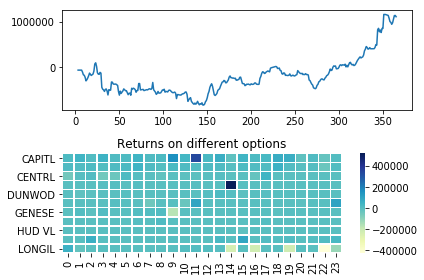

In [23]:
# Plot the cumulative reward over the year 2016. Also, plot a heat map of the returns from
# each option.
# SVC

fig, axs = plt.subplots(2, 1, tight_layout=True)
axs = axs.ravel()


## Enter code here where you plot in axs[0].
rewards = sorted(cumulativeReward.items())
x_axis,y_axis = zip(*rewards)
y_axis = tuple(i*1000000 for i in y_axis)
axs[0].plot(x_axis,y_axis)

axs[1] = sns.heatmap(np.reshape(list(optionReturn.values()), (len(listOfZones), 24)),
                     linewidth=0.5,
                     cmap="YlGnBu")
axs[1].set_yticklabels(listOfZones, rotation=0)
axs[1].set_xticklabels(range(24), rotation=90)
axs[1].set_title('Returns on different options')
plt.show()


C:\Users\Katherine\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


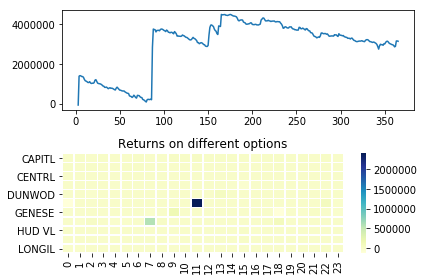

In [27]:
# Logistic
#Plot the cumulative reward over the year 2016. Also, plot a heat map of the returns from
# each option.

fig, axs = plt.subplots(2, 1, tight_layout=True)
axs = axs.ravel()


## Enter code here where you plot in axs[0].
rewards = sorted(cumulativeReward.items())
x_axis,y_axis = zip(*rewards)
y_axis = tuple(i*1000000 for i in y_axis)
axs[0].plot(x_axis,y_axis)

axs[1] = sns.heatmap(np.reshape(list(optionReturn.values()), (len(listOfZones), 24)),
                     linewidth=0.5,
                     cmap="YlGnBu")
axs[1].set_yticklabels(listOfZones, rotation=0)
axs[1].set_xticklabels(range(24), rotation=90)
axs[1].set_title('Returns on different options')
plt.show()

#### Answer:
The SVM classifier yields 1,108,942 dollars profit while the Logistic Regression classifier yields 3,134,531 dollars profit. Thus, Logistic Regression classifier yields larger profit.

### Task 3: Quantile (25 points)

For the best classifier, try different quanltile choices from the following list: 0.70, 0.75, 0.80, 0.85, 0.90, 0.95. Rank them in terms of profits (low to high). 

How do you expect the quantile to affect the portfolio? 

#### (comments here, add a new code cell below)

In [28]:
classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.


    classifiers = [MLPClassifier()
                   for _ in range(nOptions)]

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    print("All training variables were loaded successfully...\n")

Starting training module...

Loaded hourly prices from 2015 for 365 days.
Classifier trained for option CAPITL_Hour_0
Classifier trained for option CAPITL_Hour_1
Classifier trained for option CAPITL_Hour_2
Classifier trained for option CAPITL_Hour_3
Classifier trained for option CAPITL_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CAPITL_Hour_5
Classifier trained for option CAPITL_Hour_6
Classifier trained for option CAPITL_Hour_7
Classifier trained for option CAPITL_Hour_8
Classifier trained for option CAPITL_Hour_9
Classifier trained for option CAPITL_Hour_10
Classifier trained for option CAPITL_Hour_11
Classifier trained for option CAPITL_Hour_12
Classifier trained for option CAPITL_Hour_13
Classifier trained for option CAPITL_Hour_14
Classifier trained for option CAPITL_Hour_15
Classifier trained for option CAPITL_Hour_16
Classifier trained for option CAPITL_Hour_17
Classifier trained for option CAPITL_Hour_18
Classifier trained for option CAPITL_Hour_19
Classifier trained for option CAPITL_Hour_20
Classifier trained for option CAPITL_Hour_21
Classifier trained for option CAPITL_Hour_22
Classifier trained for option CAPITL_Hour_23
Classifier trained for option CENTRL_Hour_0
Classifier trained for option CENTRL_Hour_1
Classifier trained for option CENTRL_Hour_2
Classifier trained

C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_22
Classifier trained for option MHK VL_Hour_23
Classifier trained for option MILLWD_Hour_0
Classifier trained for option MILLWD_Hour_1
Classifier trained for option MILLWD_Hour_2
Classifier trained for option MILLWD_Hour_3
Classifier trained for option MILLWD_Hour_4
Classifier trained for option MILLWD_Hour_5
Classifier trained for option MILLWD_Hour_6
Classifier trained for option MILLWD_Hour_7
Classifier trained for option MILLWD_Hour_8
Classifier trained for option MILLWD_Hour_9
Classifier trained for option MILLWD_Hour_10
Classifier trained for option MILLWD_Hour_11
Classifier trained for option MILLWD_Hour_12
Classifier trained for option MILLWD_Hour_13
Classifier trained for option MILLWD_Hour_14
Classifier trained for option MILLWD_Hour_15
Classifier trained for option MILLWD_Hour_16
Classifier trained for option MILLWD_Hour_17
Classifier trained for option MILLWD_Hour_18
Classifier trained for option MILLWD_Hour_19
Classifier trained f

In [29]:
# First, load the test data from NYISO for the year 2016. Again, utilize our function
# named 'loadNYISOData'.

print("Starting the testing module...\n")
testPriceDA, testPriceDART, testLoadDA = loadNYISOData(2016)

# Create the data for the classifier using the function 'createClassifierIO'.
testX, testY, rangeOfDays = createClassifierIO(testPriceDA, testPriceDART, testLoadDA)

# The next step is not useful for implementing the trading strategy, but quickly check how accurate
# your trained classifiers are for the test data. Training accuracy is not always indicative of
# test accuracy.

testingAccuracy = [classifiers[ii].score(testX, testY[:, ii]) for ii in range(nOptions)]
print("Test Accuracy Stats: Min = %.2f%%, Avg = %.2f%%, Max = %.2f%%" %
      (100 * np.min(testingAccuracy),
       100 * np.mean(testingAccuracy),
       100 * np.max(testingAccuracy)))

# Utilize the classifiers to predict the sign of DA - RT prices for each day in 'rangeOfDays' for
# the test data. Store the result in a pandas data frame with columns as the option names and the
# day in year as index.
predictedY = pd.DataFrame(np.column_stack([classifiers[ii].predict(testX) for ii in range(nOptions)]),
                          columns=optionNames, index=rangeOfDays)

Starting the testing module...

Test Accuracy Stats: Min = 48.76%, Avg = 59.80%, Max = 74.66%


In [31]:
dailyBudget = 250000
quantileOffer =0.95

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Day 3: Reward (in $) = 62,269
Day 4: Reward (in $) = 620,223
Day 5: Reward (in $) = 17,685
Day 6: Reward (in $) = -40,794
Day 7: Reward (in $) = -5,806
Day 8: Reward (in $) = -26,648
Day 9: Reward (in $) = -13,766
Day 10: Reward (in $) = -71,578
Day 11: Reward (in $) = -23,190
Day 12: Reward (in $) = -26,991
Day 13: Reward (in $) = -16,526
Day 14: Reward (in $) = -17,970
Day 15: Reward (in $) = 1,551
Day 16: Reward (in $) = 10,826
Day 17: Reward (in $) = -42,378
Day 18: Reward (in $) = -17,257
Day 19: Reward (in $) = 15,779
Day 20: Reward (in $) = -9,953
Day 21: Reward (in $) = 21,358
Day 22: Reward (in $) = 55,216
Day 23: Reward (in $) = 21,059
Day 24: Reward (in $) = -57,104
Day 25: Reward (in $) = -56,166
Day 26: Reward (in $) = -9,109
Day 27: Reward (in $) = -3,933
Day 28: Reward (in $) = 878
Day 29: Reward (in $) = -11,579
Day 30: Reward (in $) = -31,512
Day 31: Reward (in $) = -19,074
Day 32: Reward (in $) = -4,610
Day 33: Reward (in $) = -12,049
Day 34: Reward (in $) = 3,996
Day

Day 260: Reward (in $) = -20,993
Day 261: Reward (in $) = 7,637
Day 262: Reward (in $) = -3,123
Day 263: Reward (in $) = 33,907
Day 264: Reward (in $) = -64,639
Day 265: Reward (in $) = -5,197
Day 266: Reward (in $) = -53,985
Day 267: Reward (in $) = -5,084
Day 268: Reward (in $) = -12,804
Day 269: Reward (in $) = -39,553
Day 270: Reward (in $) = -42,490
Day 271: Reward (in $) = -20,249
Day 272: Reward (in $) = -14,340
Day 273: Reward (in $) = -14,378
Day 274: Reward (in $) = 5,241
Day 275: Reward (in $) = 14,581
Day 276: Reward (in $) = 12
Day 277: Reward (in $) = 43,656
Day 278: Reward (in $) = 102,587
Day 279: Reward (in $) = -4,520
Day 280: Reward (in $) = 7,149
Day 281: Reward (in $) = -7,313
Day 282: Reward (in $) = 3,860
Day 283: Reward (in $) = -80,651
Day 284: Reward (in $) = 9,275
Day 285: Reward (in $) = -38,443
Day 286: Reward (in $) = -33,216
Day 287: Reward (in $) = -21,950
Day 288: Reward (in $) = 7,332
Day 289: Reward (in $) = 11,009
Day 290: Reward (in $) = -47,332
Day

#### Answer
quantileOffer = 0.7 profit =  5,138,796;
quantileOffer = 0.75 profit =  4,948,815;
quantileOffer = 0.8 profit =  4,240,778;
quantileOffer = 0.85 profit =  3,413,536;
quantileOffer = 0.9 profit =  2,006,488;
quantileOffer = 0.95 profit =  1,734,850;
from low to high: 0.95, 0.9, 0.85, 0.8, 0.75, 0.7. As quantile gets lower, the profit gets higher.

### Task 4: Daily budget (25 points)

We used a daily budget of 250,000. Try different budgets, let's say, 100,000, 150,000, 200,000, and 300,000. Rank them in terms of profits (low to high). Fix the quantile to the one that led to maximum profits in the previous task. 

#### (comments here, add a new code cell below)

In [33]:
dailyBudget = 300000
quantileOffer =0.7

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Day 3: Reward (in $) = -77,777
Day 4: Reward (in $) = 1,263,113
Day 5: Reward (in $) = 34,391
Day 6: Reward (in $) = -8,263
Day 7: Reward (in $) = -7,794
Day 8: Reward (in $) = -48,897
Day 9: Reward (in $) = -31,834
Day 10: Reward (in $) = -150,690
Day 11: Reward (in $) = -49,621
Day 12: Reward (in $) = -69,901
Day 13: Reward (in $) = -2,530
Day 14: Reward (in $) = -42,812
Day 15: Reward (in $) = 4,501
Day 16: Reward (in $) = 24,899
Day 17: Reward (in $) = -94,220
Day 18: Reward (in $) = -35,640
Day 19: Reward (in $) = 24,516
Day 20: Reward (in $) = -18,168
Day 21: Reward (in $) = 69,218
Day 22: Reward (in $) = 115,555
Day 23: Reward (in $) = 38,207
Day 24: Reward (in $) = -114,854
Day 25: Reward (in $) = -110,810
Day 26: Reward (in $) = -25,827
Day 27: Reward (in $) = -13,020
Day 28: Reward (in $) = 2,463
Day 29: Reward (in $) = -28,463
Day 30: Reward (in $) = -94,452
Day 31: Reward (in $) = -55,461
Day 32: Reward (in $) = -10,267
Day 33: Reward (in $) = -40,176
Day 34: Reward (in $) 

Day 260: Reward (in $) = -44,697
Day 261: Reward (in $) = 26,869
Day 262: Reward (in $) = 19,542
Day 263: Reward (in $) = -1
Day 264: Reward (in $) = -5,144
Day 265: Reward (in $) = -11,203
Day 266: Reward (in $) = -12,734
Day 267: Reward (in $) = -13,044
Day 268: Reward (in $) = -28,620
Day 269: Reward (in $) = -90,930
Day 270: Reward (in $) = -98,429
Day 271: Reward (in $) = -67,361
Day 272: Reward (in $) = -38,490
Day 273: Reward (in $) = -45,490
Day 274: Reward (in $) = 16,608
Day 275: Reward (in $) = 33,948
Day 276: Reward (in $) = -1,234
Day 277: Reward (in $) = 102,186
Day 278: Reward (in $) = 222,066
Day 279: Reward (in $) = 16,381
Day 280: Reward (in $) = 23,592
Day 281: Reward (in $) = -16,795
Day 282: Reward (in $) = 8,711
Day 283: Reward (in $) = -1,882
Day 284: Reward (in $) = 38,453
Day 285: Reward (in $) = -89,570
Day 286: Reward (in $) = -77,155
Day 287: Reward (in $) = -55,399
Day 288: Reward (in $) = 16,865
Day 289: Reward (in $) = 25,910
Day 290: Reward (in $) = 9,12

#### Answer:
Profit for 100000 budget: 2,045,769;
Profit for 150000 budget: 3,120,598;
Profit for 200000 budget: 4,060,875;
Profit for 300000 budget: 6,204,361;
To rank from low profit to hight profit: 100000<150000<200000<300000. Thus as dailyBudget gets increases, the corresponding profit also gets larger.

### Task 6: Beat the algorithm! (25 points, bonus) 

Make changes to increase the profits further! The people with the top 20 total profits will get additional points. Exaplain what did for improvement and how much profits you made. Do not exceed the 250,000 budget!

#### (comments here, add a new code cell below)

In [34]:
classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.


    classifiers = [MLPClassifier(hidden_layer_sizes=(40, 20), max_iter=300)
                   for _ in range(nOptions)]

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    print("All training variables were loaded successfully...\n")

Starting training module...

Loaded hourly prices from 2015 for 365 days.
Classifier trained for option CAPITL_Hour_0
Classifier trained for option CAPITL_Hour_1
Classifier trained for option CAPITL_Hour_2
Classifier trained for option CAPITL_Hour_3
Classifier trained for option CAPITL_Hour_4
Classifier trained for option CAPITL_Hour_5
Classifier trained for option CAPITL_Hour_6
Classifier trained for option CAPITL_Hour_7
Classifier trained for option CAPITL_Hour_8
Classifier trained for option CAPITL_Hour_9
Classifier trained for option CAPITL_Hour_10
Classifier trained for option CAPITL_Hour_11
Classifier trained for option CAPITL_Hour_12
Classifier trained for option CAPITL_Hour_13
Classifier trained for option CAPITL_Hour_14
Classifier trained for option CAPITL_Hour_15
Classifier trained for option CAPITL_Hour_16
Classifier trained for option CAPITL_Hour_17
Classifier trained for option CAPITL_Hour_18
Classifier trained for option CAPITL_Hour_19
Classifier trained for option CAPITL

Classifier trained for option MILLWD_Hour_15
Classifier trained for option MILLWD_Hour_16
Classifier trained for option MILLWD_Hour_17
Classifier trained for option MILLWD_Hour_18
Classifier trained for option MILLWD_Hour_19
Classifier trained for option MILLWD_Hour_20
Classifier trained for option MILLWD_Hour_21
Classifier trained for option MILLWD_Hour_22
Classifier trained for option MILLWD_Hour_23
Classifier trained for option N.Y.C._Hour_0
Classifier trained for option N.Y.C._Hour_1
Classifier trained for option N.Y.C._Hour_2
Classifier trained for option N.Y.C._Hour_3
Classifier trained for option N.Y.C._Hour_4
Classifier trained for option N.Y.C._Hour_5
Classifier trained for option N.Y.C._Hour_6
Classifier trained for option N.Y.C._Hour_7
Classifier trained for option N.Y.C._Hour_8
Classifier trained for option N.Y.C._Hour_9
Classifier trained for option N.Y.C._Hour_10
Classifier trained for option N.Y.C._Hour_11
Classifier trained for option N.Y.C._Hour_12
Classifier trained f

In [35]:

# First, load the test data from NYISO for the year 2016. Again, utilize our function
# named 'loadNYISOData'.

print("Starting the testing module...\n")
testPriceDA, testPriceDART, testLoadDA = loadNYISOData(2016)

# Create the data for the classifier using the function 'createClassifierIO'.
testX, testY, rangeOfDays = createClassifierIO(testPriceDA, testPriceDART, testLoadDA)

# The next step is not useful for implementing the trading strategy, but quickly check how accurate
# your trained classifiers are for the test data. Training accuracy is not always indicative of
# test accuracy.

testingAccuracy = [classifiers[ii].score(testX, testY[:, ii]) for ii in range(nOptions)]
print("Test Accuracy Stats: Min = %.2f%%, Avg = %.2f%%, Max = %.2f%%" %
      (100 * np.min(testingAccuracy),
       100 * np.mean(testingAccuracy),
       100 * np.max(testingAccuracy)))

# Utilize the classifiers to predict the sign of DA - RT prices for each day in 'rangeOfDays' for
# the test data. Store the result in a pandas data frame with columns as the option names and the
# day in year as index.
predictedY = pd.DataFrame(np.column_stack([classifiers[ii].predict(testX) for ii in range(nOptions)]),
                          columns=optionNames, index=rangeOfDays)

Starting the testing module...

Test Accuracy Stats: Min = 48.21%, Avg = 59.47%, Max = 69.70%


In [36]:
dailyBudget = 250000
quantileOffer =0.7

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Day 3: Reward (in $) = -67,242
Day 4: Reward (in $) = 1,106,478
Day 5: Reward (in $) = 31,603
Day 6: Reward (in $) = -11,436
Day 7: Reward (in $) = -5,869
Day 8: Reward (in $) = -41,697
Day 9: Reward (in $) = -19,008
Day 10: Reward (in $) = -127,122
Day 11: Reward (in $) = -83,590
Day 12: Reward (in $) = -82,612
Day 13: Reward (in $) = -2,277
Day 14: Reward (in $) = -43,302
Day 15: Reward (in $) = -3,254
Day 16: Reward (in $) = 41,167
Day 17: Reward (in $) = -88,742
Day 18: Reward (in $) = -26,764
Day 19: Reward (in $) = 15,131
Day 20: Reward (in $) = -2,484
Day 21: Reward (in $) = 52,753
Day 22: Reward (in $) = 92,049
Day 23: Reward (in $) = 32,153
Day 24: Reward (in $) = -95,877
Day 25: Reward (in $) = -99,811
Day 26: Reward (in $) = -27,236
Day 27: Reward (in $) = -10,742
Day 28: Reward (in $) = -17,152
Day 29: Reward (in $) = -31,005
Day 30: Reward (in $) = -41,864
Day 31: Reward (in $) = -47,276
Day 32: Reward (in $) = -11,915
Day 33: Reward (in $) = -270,414
Day 34: Reward (in $)

Day 261: Reward (in $) = 37,582
Day 262: Reward (in $) = 18,581
Day 263: Reward (in $) = 5,656
Day 264: Reward (in $) = -3,540
Day 265: Reward (in $) = -3,113
Day 266: Reward (in $) = -11,432
Day 267: Reward (in $) = -10,266
Day 268: Reward (in $) = -26,380
Day 269: Reward (in $) = -76,054
Day 270: Reward (in $) = -95,524
Day 271: Reward (in $) = -11,702
Day 272: Reward (in $) = -32,861
Day 273: Reward (in $) = -38,850
Day 274: Reward (in $) = 13,176
Day 275: Reward (in $) = 30,454
Day 276: Reward (in $) = 7,098
Day 277: Reward (in $) = 44,060
Day 278: Reward (in $) = 187,967
Day 279: Reward (in $) = 6,923
Day 280: Reward (in $) = 21,657
Day 281: Reward (in $) = -13,734
Day 282: Reward (in $) = -857
Day 283: Reward (in $) = -6,854
Day 284: Reward (in $) = 28,433
Day 285: Reward (in $) = -68,711
Day 286: Reward (in $) = -62,848
Day 287: Reward (in $) = -73,419
Day 288: Reward (in $) = 13,060
Day 289: Reward (in $) = 21,715
Day 290: Reward (in $) = 7,348
Day 291: Reward (in $) = -9,157
D

#### Answer:
I tried to change the number of network layers.

### Task 7: Implement a different trading strategy (25 points, bonus) 

Implement a different trading strategy, explain it and report its outcomes. If the rewards are comparable to the one discussed in class, and you can clearly explain the logic behind you strategy, you get additional 25 points. If your strategy leads to having profits among the top 20, then you automatically completed Task 6 too! 

#### (comments here, add a new code cell below)